# Decision Trees

## Training and visualising DT classifier

In [26]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [27]:
from sklearn.tree import export_graphviz
export_graphviz(
    tree_clf,
    out_file=("./iris_tree.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [28]:
# convert .dot file to .png
!dot -Tpng iris_tree.dot -o iris_tree.png

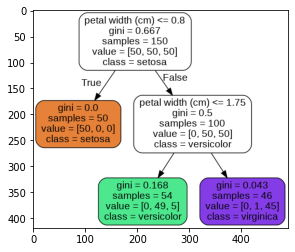

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('./iris_tree.png')
imgplot = plt.imshow(img)
plt.show()

## Making Predictions
Suppose you find an iris flower and you want to classify it. You start at the root node (depth 0, at the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this case, it is a leaf node (i.e., it does not have any child nodes), so it does not ask any questions: simply look at the predicted class for that node, and the Decision Tree predicts that your flower is an Iris setosa (class=setosa).

Now suppose you find another flower, and this time the petal length is greater than 2.45 cm. You must move down to the root’s right child node (depth 1, right), which is not a leaf node, so the node asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an Iris versicolor (depth 2, left). If not, it is likely an Iris virginica (depth 2, right). It’s really that simple.

NOTE: One of the many qualities of Decision Trees is that they require very little data preparation. In fact, they don’t require feature scal‐ ing or centering at all.

A node’s gini attribute measures its impurity: a node is “pure” (gini=0) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to Iris setosa training instances, it is pure and its gini score is 0. The depth-2 left node has a gini score equal to $1 – (0/54)^2 – (49/54)^2 – (5/54)^2 ≈ 0.168$

***Gini Impurity*** <br>
$ G_i = 1 - \sum_{k=1}^{n} p_{i, k}^2$

where: <br>
$p_{i, k}$ is the ratio of class k instances among the training instances in the ith node

NOTE: Scikit-Learn uses the CART algorithm, which produces only binary trees: nonleaf nodes always have two children (i.e., questions only have yes/no answers). However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.


## Class Probability Estimation
A Decision Tree can also estimate the probability that an instance belongs to a partic‐ ular class k. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node. Let's try it out.

In [30]:
# flower petal 5cm long, 1.5cm wide
print(f"Probabs - {tree_clf.predict_proba([[5, 1.5]])}")
print(f"class - {tree_clf.predict([[5, 1.5]])}")

Probabs - [[0.         0.90740741 0.09259259]]
class - [1]


## The CART Training Algorithm
Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train Decision Trees (also called “growing” trees). The algorithm works by first splitting the training set into two subsets using a single feature k and a threshold $t_k$ (e.g., “petal length ≤ 2.45 cm”). How does it choose k and $t_k$? It searches for the pair (k, $t_k$) that produces the purest subsets (weighted by their size).

***CART cost function for classification***<br>
$
J(k, t_k) = \frac{m_{left}}{m} G_{left} + \frac{m_{right}}{m} G_{right}
$
where: <br>
$G_{left/right}$ measures the impurity of the left/right subset<br>
$m_{left/right}$ is the number of instances in the left/right subset

Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity. 

NOTE: The CART algorithm is a greedy algorithm: it greed‐ ily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a solution that’s reasona‐ bly good but not guaranteed to be optimal.


## Computational Complexity
Making predictions requires traversing the Decision Tree from the root to a leaf. Decision Trees generally are approximately balanced, so traversing the Decision Tree requires going through roughly O(log2(m)) nodes. Since each node only requires checking the value of one feature, the overall prediction complexity is O(log2(m)), independent of the number of features. So predictions are very fast, even when dealing with large training sets.

The training algorithm compares all features (or less if max_features is set) on all samples at each node. Comparing all features on all samples at each node results in a training complexity of O(n × m log2(m)). For small training sets (less than a few thousand instances), Scikit-Learn can speed up training by presorting the data (set pre sort=True), but doing that slows down training considerably for larger training sets.

## Gini Impurity or Entropy?
By default, the Gini impurity measure is used, but you can select the entropy impurity measure instead by setting the criterion hyperparameter to "entropy". 
In Machine Learning, entropy is frequently used as an impurity measure: a set’s entropy is zero when it contains instances of only one class. 

***Entropy*** <br>
$
H_i = - \sum_{k=1}^n p_{i, k} log_2(p_{i, k})
$

Should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.


## Regularization Hyperparameters
To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training. As you know by now, this is called regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decision Tree. In Scikit-Learn, this is controlled by the max_depth hyperparameter (the default value is None, which means unlimited). Reducing max_depth will regularize the model and thus reduce the risk of overfitting.

The DecisionTreeClassifier class has a few other parameters that similarly restrict
the shape of the Decision Tree: 
* min_samples_split (the minimum number of samples a node must have before it can be split),
* min_samples_leaf (the minimum number of samples a leaf node must have), 
* min_weight_fraction_leaf (same as min_samples_leaf but expressed as a fraction of the total number of weighted
instances)
* max_leaf_nodes (the maximum number of leaf nodes)
* max_features (the maximum number of features that are evaluated for splitting at each node)

Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model.


## Regression
Decision Trees are also capable of performing regression tasks. Let’s build a regres‐ sion tree using Scikit-Learn’s DecisionTreeRegressor class, training it on a noisy quadratic dataset with max_depth=2

In [31]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

export_graphviz(
    tree_reg,
    out_file=("./iris_tree2.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [32]:
# convert .dot file to .png
!dot -Tpng iris_tree2.dot -o iris_tree2.png

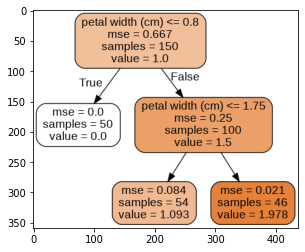

In [33]:
img=mpimg.imread('./iris_tree2.png')
imgplot = plt.imshow(img)
plt.show()

This tree looks very similar to the classification tree you built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. The CART algorithm works mostly the same way as earlier, except that instead of try‐ ing to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE.

***CART cost function for regression***

$
J(k, t_k) = \frac{m_{left}}{m} MSE_{left} + \frac{m_{right}}{m} MSE_{right}
$

where: <br>
$
MSE_{node} = \sum_{i \in node} (\hat{y}_{node} - y^{(i)})^2 \\
\hat{y}_{node} = \frac{1}{m_{node}} \sum_{i \in node} y^{(i)}
$

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. 


## Instability
Hopefully by now you are convinced that Decision Trees have a lot going for them: they are simple to understand and interpret, easy to use, versatile, and powerful. However, they do have a few limitations. First, as you may have noticed, Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation. 

The main issue with Decision Trees is that they are very sensitive to small variations in the training data. 

Actually, since the training algorithm used by Scikit-Learn is stochastic, you may get very different models even on the same training data (unless you set the random_state hyperparameter).